### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE
from Inference.Variational import MeanFieldVariationalDistribution


In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [5]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [6]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)




In [7]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [8]:
param_count = get_param(model).shape[0]
param_count

61

In [9]:
VAE = MeanFieldVariationalAE(30,param_count,param_count,nn.Tanh())
VAE_param_count = get_param(VAE).shape[0]
VAE_param_count

5733

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
VAE.decoder.apply(init_weights)

Sequential(
  (0): Linear(in_features=30, out_features=61, bias=True)
  (1): Tanh()
  (2): Linear(in_features=61, out_features=61, bias=True)
)

In [11]:
sigma_like=.0000001

def loglikelihood(theta, sigma_likeli=sigma_like):
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = _log_norm(y_pred, y_data, torch.tensor([sigma_likeli],device=device))
    return torch.sum(L).unsqueeze(-1)

In [12]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [13]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

In [14]:
flip_parameters_to_tensors(model)

# KL-divergence #

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - \ln(\sigma_i^2) - 1).$$

In [15]:
def KLDivGauss(mu,sigma):
    Div=sigma+mu**2-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [16]:
KLDivGauss(VAE.mfvar.mu.detach(),VAE.mfvar.sigma.detach())

tensor(0.)

In [17]:
n_samples_VAR = 50

In [18]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.01)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=50, factor=0.5)


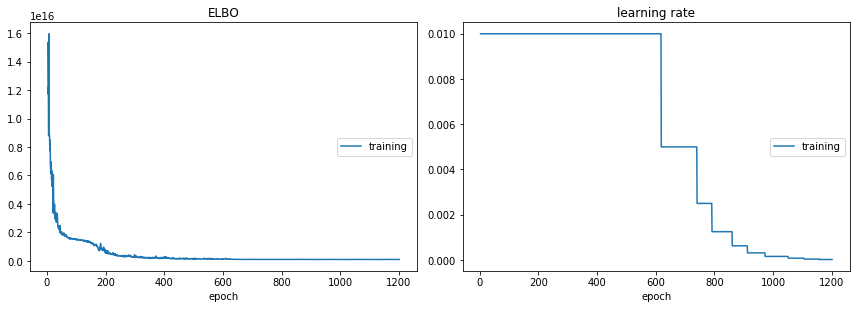

ELBO:
training   (min: 100582916358144.000, max: 24388666847657984.000, cur: 102844174696448.000)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [19]:
%matplotlib inline

liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        theta = VAE()
        LL[i]=loglikelihood(theta)

    L = Div - LL.mean()
    
    L.backward()
    

    learning_rate = VAE_optimizer.param_groups[0]['lr']

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

In [25]:

L = VAE(10000).detach().numpy()

<IPython.core.display.Javascript object>


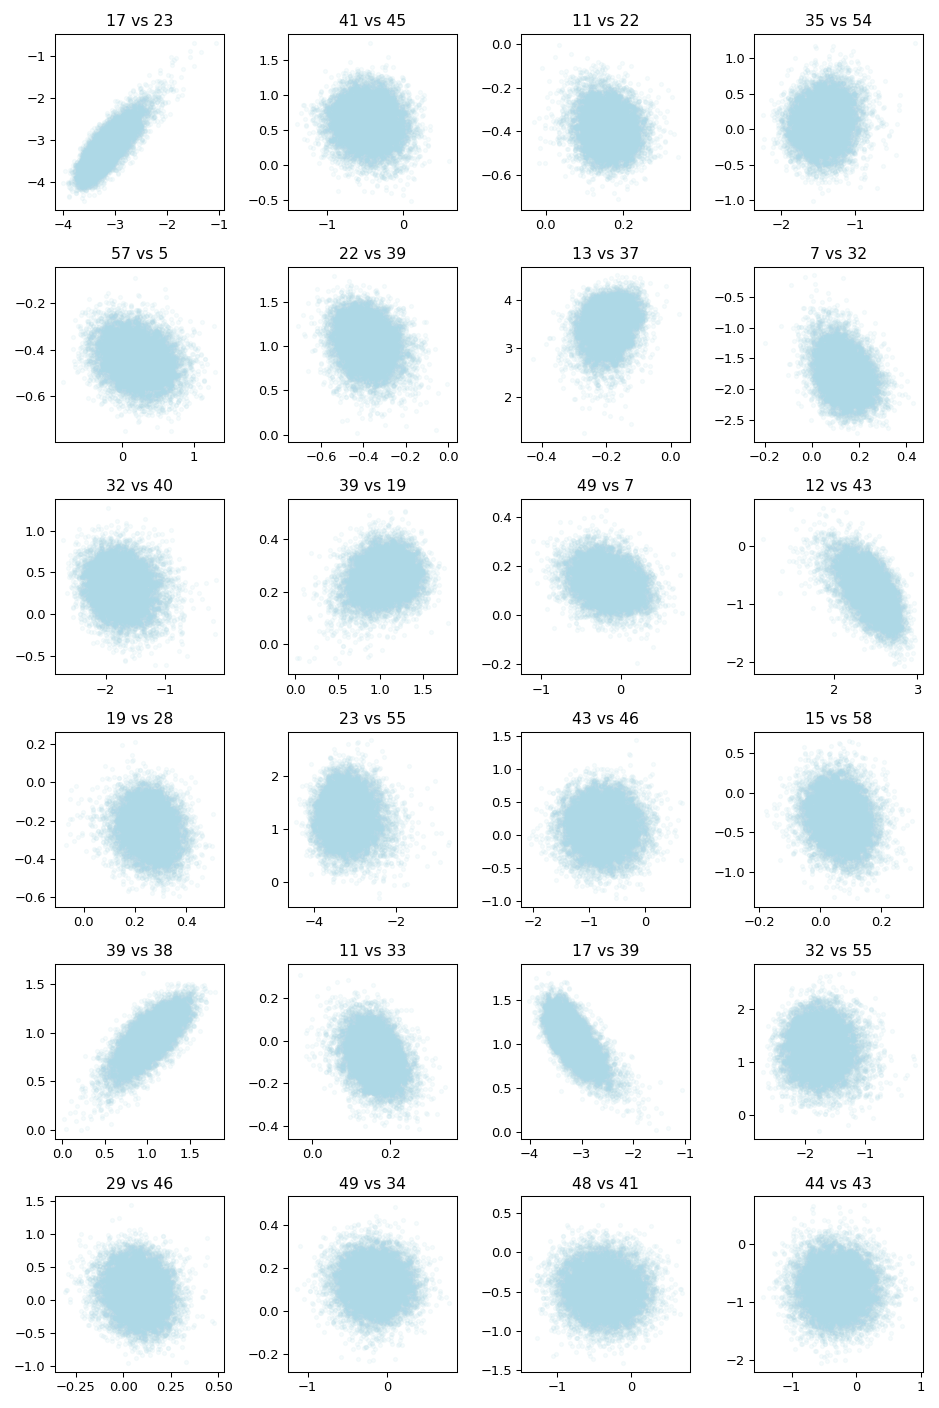

In [26]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.1,color='lightblue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

<IPython.core.display.Javascript object>


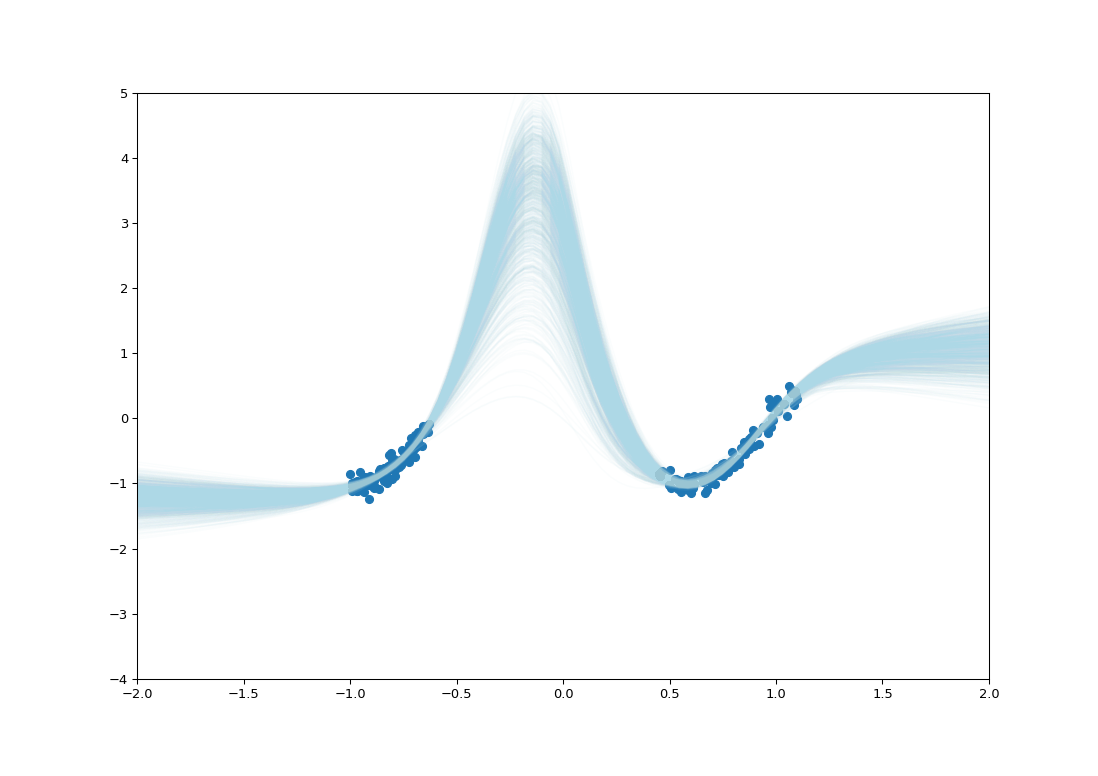

In [27]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.0,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4,5) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    theta = VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
for params in VAE.parameters():
    params.detach_()

In [ ]:

def Boost(q):
    VAE_new=MeanFieldVariationalAE(param_count,param_count,param_count,nn.Tanh())
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    VAE_new.decoder.apply(init_weights)
    
    nb_sample=200
    zq=q(nb_sample).detach()
    def proximity(x,seuil_prec):
        i=0
        while i< nb_sample :
            if torch.norm(zq[i]-x.detach())< seuil_prec:
                return True
            i+=1
        return False

    def updateDensity(x,log_likelihood,seuil_prec):  
        if proximity(x,seuil_prec):
            return torch.Tensor([-100.])#*log_density(x)
        else:
            return log_likelihood(x)#torch.Tensor(2.0)*log_density(x[i].unsqueeze(0)).squeeze(0)
    
    n_samples_VAR=50
    
    VAE_optimizer = torch.optim.Adam(VAE_new.parameters(), lr=.01)
    VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=50, factor=0.5)
    
    %matplotlib inline

    liveloss = PlotLosses()
    for t in range(10000):
        logs = {}
        VAE_optimizer.zero_grad()

        Div = KLDivGauss(VAE_new.mfvar.mu,VAE_new.mfvar.sigma)

        LL=torch.Tensor(n_samples_VAR)

        for i in range(n_samples_VAR):
            theta = VAE_new()
            LL[i]=updateDensity(theta,loglikelihood,0.2)

        L = Div - LL.mean()

        L.backward()


        learning_rate = VAE_optimizer.param_groups[0]['lr']

        VAE_scheduler.step(L.detach().clone().cpu().numpy())

        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        #logs['memory'] = torch.cuda.memory_allocated(device=device)
        #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        #if t %2 == 0:
        VAE_optimizer.step()

        if learning_rate < 0.0001:
            break

    return VAE_new





In [ ]:
VAE_new=Boost(VAE)

In [ ]:

L = VAE_new(10000).detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.05,color='lightblue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

<IPython.core.display.Javascript object>


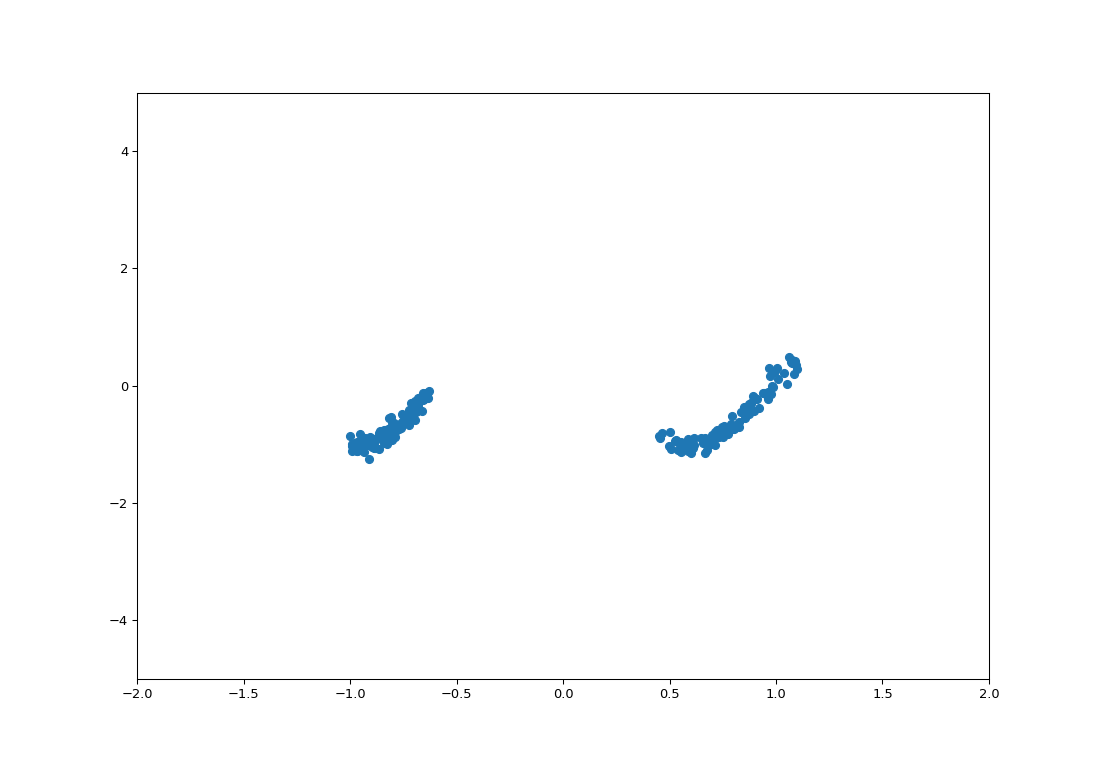

NameError: name 'prior' is not defined

In [29]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.0,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-5, 5) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    theta = prior.sample()
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


In [ ]:
def sample(mixture,proportions):
    m = torch.multinomial(proportions, 1, replacement=True)
    return mixture[int(m)]()

def sample_lat(mixture,proportions):
    m = torch.multinomial(proportions, 1, replacement=True)
    return mixture[int(m)].mfvar.sample()


def log_prob(x,mixture,proportions):
    return torch.logsumexp(torch.stack([torch.log(proportions[c]) + mixture[c].mfvar.log_prob(x) for c in range(len(proportions))],dim=1),dim=1)

In [ ]:
for params in VAE_new.parameters():
    params.detach_()

In [ ]:
def proportion(q,q_new):
    nb_ELBO_samples = 10000
    unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)

    mixture=[q,q_new]
    proportions=torch.Tensor([1-torch.sigmoid(unbounded_prop_new),torch.sigmoid(unbounded_prop_new)])
    
    optimizer = torch.optim.Adam([unbounded_prop_new], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    
    n_samples_VAR=100
    
    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    Div_new = KLDivGauss(VAE_new.mfvar.mu,VAE_new.mfvar.sigma)
    
    for t in range(10000):
        logs = {}
        optimizer.zero_grad()

        prop_new = torch.sigmoid(unbounded_prop_new)

        LL=torch.Tensor(n_samples_VAR)
        LQ=torch.Tensor(n_samples_VAR)
        LP=torch.Tensor(n_samples_VAR)
        for i in range(n_samples_VAR):
            theta = sample(mixture, proportions)
            z=sample_lat(mixture, proportions)
            LQ[i]=log_prob(z,mixture, proportions)
            LP[i]=logprior(z)
            LL[i]=loglikelihood(theta,sigma_likeli=0.0001)
        
        L = (LQ-LP).mean() - LL.mean() 

        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        logs['prop_new'] = prop_new.detach().clone().cpu().numpy()
        liveloss.update(logs)

        if t % 10 == 0:
                liveloss.draw()

        optimizer.step()

        if learning_rate < 0.001:
            break

    return torch.Tensor([1-torch.sigmoid(unbounded_prop_new),torch.sigmoid(unbounded_prop_new)])

In [ ]:
proportions=proportion(VAE,VAE_new)

In [ ]:
proportions

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.0,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-3, 3) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    theta = sample(mixture,proportions)
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


## 

In [ ]:
## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    latent =prior.sample()
    theta=VAE.decoder(latent)
    set_all_parameters(model, theta)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')